https://towardsdatascience.com/time-series-pattern-recognition-with-air-quality-sensor-data-4b94710bb290

# Messreihen
    1. Messreihe: ohne Benachrichtigung 24.05.2021-31.05.2021 
    2. Messreihe: mit Benachrichtigung 01.06.2021-04.06.2021

# import libraries

In [1]:
%matplotlib inline

import boto3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd
from scipy.stats import shapiro
from sklearn import preprocessing

In [2]:
import warnings
warnings.filterwarnings("ignore")

# import data from AWS

In [3]:
client = boto3.client('iotanalytics')
data = client.get_dataset_content(datasetName='airquality_1_dataset')
df = pd.read_csv(data["entries"][0]["dataURI"])
df.drop(["__dt"], axis = 1, inplace = True)
df["timestamp"] = pd.to_datetime(df["timestamp"]) + pd.Timedelta(hours=2)
df.set_index("timestamp", inplace = True)
df.sort_values(by="timestamp", axis=0, ascending=True, inplace=True)
#df = df[df["ppm"] < 2500]
df.tail()

,temperature,pressure,ppm,humidity
timestamp,,,,
NaT,21.99,NaN,NaN,NaN
NaT,22.01,NaN,NaN,NaN
NaT,21.98,NaN,NaN,NaN
NaT,NaN,NaN,359.518,NaN
NaT,21.98,NaN,NaN,NaN


# Clean data

# filter outliers

In [4]:
def is_outlier(data):
    thresh = 5000
    rolling_median = data.rolling(2, center=True).median()
    return (abs(data - rolling_median) >= thresh).astype('int')

In [5]:
try:
    df = df.drop(["temperature","pressure", "humidity"], axis = 1)
    outlier = is_outlier(df)
    df["outlier"] = outlier

    old_len = len(df)
    df =df[df["outlier"]==0]
    new_len = len(df)
    print("filtered: abs.", old_len-new_len, "rel.",int((1-old_len/new_len)*100), "%", "values")

    df = df.drop(["outlier"], axis = 1)
except:
    pass

filtered: abs. 43 rel. 0 % values


# divide Dataset to measurement series
    1. Messreihe: ohne Benachrichtigung 24.05.2021-31.05.2021 
    2. Messreihe: mit Benachrichtigung 01.06.2021-04.06.2021

In [14]:
series = df[(df.index > "2021-05-17T00:00:00") & (df.index < "2021-06-14T00:00:00")]
first_series = df[(df.index > "2021-05-17T00:00:00") & (df.index < "2021-05-24T00:00:00")]
second_series = df[(df.index > "2021-05-24T00:00:00") & (df.index < "2021-05-31T00:00:00")]
third_series = df[(df.index > "2021-05-31T00:00:00") & (df.index < "2021-06-07T00:00:00")]

kw23 = df[(df.index > "2021-06-07T00:00:00") & (df.index < "2021-06-13T00:00:00")]
day = df[(df.index > "2021-06-13T00:00:00") & (df.index < "2021-06-15T00:00:00")]

last_24h = df.tail(24*60)

good_series = df[(df.index > "2021-05-29T00:00:00") & (df.index < "2021-06-01T00:00:00")]

measurement_series = [series, first_series, second_series]

In [7]:
last_24h

,ppm
timestamp,
2021-06-21 11:49:11,10570.300
2021-06-21 11:50:12,10455.200
2021-06-21 11:51:13,10443.000
2021-06-21 11:52:14,10247.000
2021-06-21 11:53:15,10448.300
...,...
NaT,NaN
NaT,NaN
NaT,NaN


# plot Data

In [8]:
def plot_timeseries(datasets, value = None):
    # rolling data
    def rolling(data):
            data_rolling = data.rolling(24)
            data_rolling_mean = data_rolling.mean()
            data_rolling_std = data_rolling.std()
            data_rolling_upper = data_rolling_mean + 1.92 * data_rolling_std
            data_rolling_lower = data_rolling_mean - 1.92 * data_rolling_std
            return data_rolling, data_rolling_mean, data_rolling_upper, data_rolling_lower
    
    #create const line
    def create_const(df, value):
        arr = np.full((1, len(df)), value)[0]
        return pd.Series(arr, index = df.index)
    
    def plot(data):
        data_rolling, data_rolling_mean, data_rolling_upper, data_rolling_lower = rolling(data)
        fig, ax = plt.subplots(figsize=(10,10))
        sns.scatterplot(x = data.index, y=value, data = data, ax =ax)
        sns.lineplot(x = data_rolling_mean.index, y=value, data = data_rolling_mean, ax =ax)
        plt.fill_between(data_rolling_mean.index, data_rolling_upper[value], data_rolling_lower[value], color='b', alpha=.2)
        
        plt.fill_between(data_rolling_mean.index, create_const(data_rolling_mean, 1000), create_const(data_rolling_mean, 0), color='g', alpha=.1)
        plt.fill_between(data_rolling_mean.index, create_const(data_rolling_mean, 1000), create_const(data_rolling_mean, 2000), color='y', alpha=.1)
        plt.fill_between(data_rolling_mean.index, create_const(data_rolling_mean, 2000), create_const(data_rolling_mean, 3000), color='r', alpha=.1)

        ax.set_ylim(bottom=0., top=3000.)
        
        # assign locator and formatter for the xaxis ticks.
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y %H:%M:%S')) #'%Y.%m.%d %H:%M:%S'

        # put the labels at 45deg since they tend to be too long
        fig.autofmt_xdate()
        
        # set title
        start = data.index[0].strftime('%d.%m %H:%M')
        end = data.index[-1].strftime('%d.%m %H:%M')
        
        plt.title(str(("PPM Verlauf vom " + start +  " bis zum " + end)))
        plt.show()
        
    for dataset in datasets: 
        plot(dataset)


#plot_timeseries(measurement_series, "ppm")

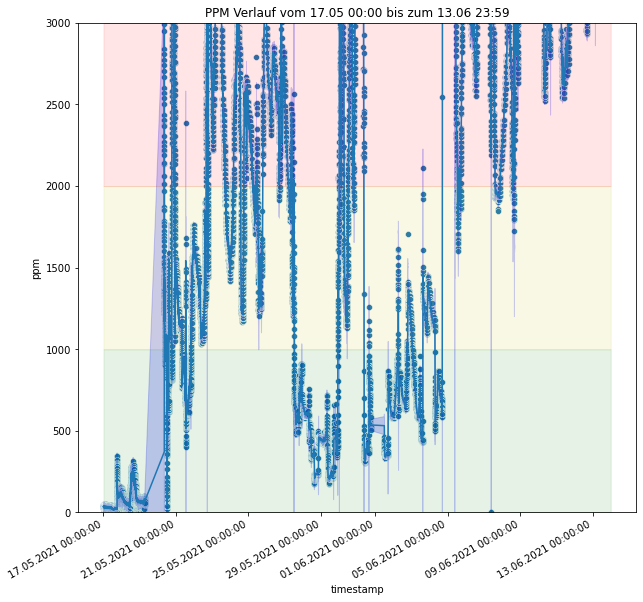

In [16]:
plot_timeseries([series], "ppm")

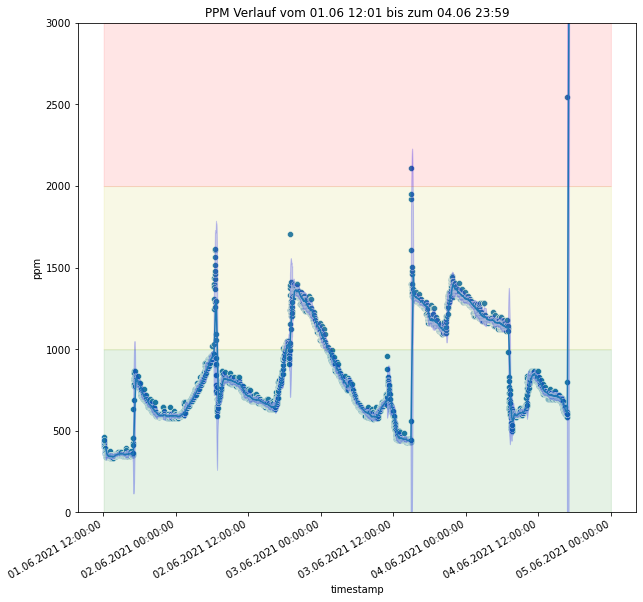

In [19]:
good_series = df[(df.index > "2021-06-01T00:00:00") & (df.index < "2021-06-05T00:00:00")]
plot_timeseries([good_series], "ppm")

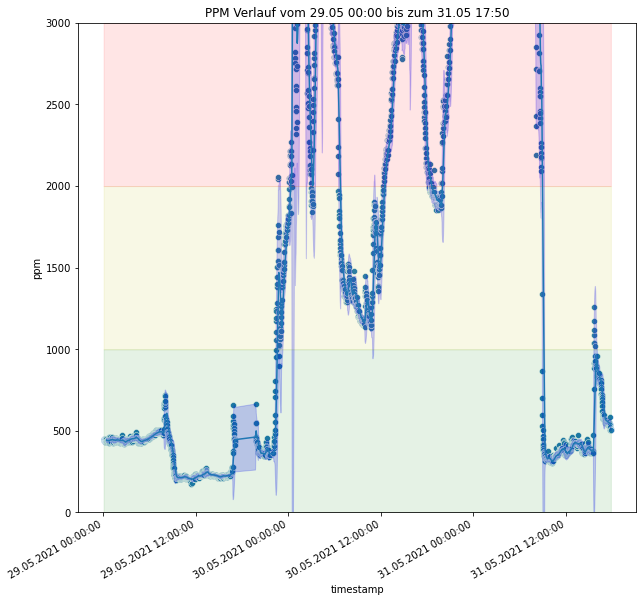

In [22]:
good_series = df[(df.index > "2021-05-29T00:00:00") & (df.index < "2021-06-01T00:00:00")]
plot_timeseries([good_series], "ppm")

# Feature Engineering
- Kennzahlen einführen: meantime between good-good; bad-bad

# categorize data

## categorize ppm value
ppm < 1000: good; 
1000 >= ppm <= 2000: medium;
ppm > 2000: bad;

In [10]:
ppm_bins = [0, 1000, 2000, np.inf]
ppm_category = [0, 1, 2]
series["quality"] = pd.cut(series['ppm'], ppm_bins, labels=ppm_category).astype("int")

series["quality"].value_counts()

0    55818
2    51535
1    40449
Name: quality, dtype: int64

In [11]:
#ppm["good"] = (ppm["ppm"] < 1000).astype("int")
#ppm["medium"] = ((ppm["ppm"] >= 1000) & (ppm["ppm"] <= 2000)).astype("int")
#ppm["bad"] = (ppm["ppm"] > 2000).astype("int")

## categorize time
6 < morning < 12;
12 < noon < 18;
18 < evening < 24;
0 < night <6;

In [12]:
time_hour = ppm.index.strftime('%H').astype('int')
ppm["day"] = ppm.index.strftime('%A')#.astype('int')

time_bins = [0, 6, 12, 18, 24]
time_category = ['night', 'morning', 'noon', 'evening']
ppm["time"] = pd.cut(time_hour, time_bins, labels=time_category)

ppm.head()

NameError: name 'ppm' is not defined